In [1]:
%matplotlib inline
import cv2
from theano import *
theano.config.openmp = True

from keras import *
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import *

Using Theano backend.


In [2]:
fobia_folder = "./trypophobia_images/"
normal_folder = "./normal_pictures/"
resolution_x = 256
resolution_y = 256
def load_folder(folder):
    
    images = []
    
    if(not os.path.isdir(folder[:-1]+"-parsed")):
        os.mkdir(folder[:-1]+"-parsed")
    
    for file in tqdm(os.listdir(folder)):
        image = cv2.imread(os.path.join(folder, file))
        if(image is not None):
            for rot in range(4):
                image = cv2.resize(image, (resolution_x, resolution_y), interpolation=cv2.INTER_LINEAR)
                M = cv2.getRotationMatrix2D((int(resolution_x/2),int(resolution_y/2)), rot*137.508 , 1)
                image = cv2.warpAffine(image, M,(resolution_x, resolution_y))
                
                cv2.imwrite(os.path.join(folder[:-1]+"-parsed/",file+"_%d"%rot), image)

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image.reshape(3,resolution_x, resolution_y))
        
    return np.array(images)

In [3]:
fobia_images = load_folder(fobia_folder) /255.
normal_images = load_folder(normal_folder) /255.

100%|██████████| 255/255 [00:09<00:00, 25.84it/s]


In [7]:
data_y = [] # 1,0 -> fobia | 0,1 -> normal
data_x = []
for img in fobia_images:
    data_x.append(img)
    data_y.append([1,0])
for img in normal_images:
    data_x.append(img)
    data_y.append([0,1])

#RAM CleanUp
del fobia_images
del normal_images
#---------------

data_x = np.array(data_x)
data_y = np.array(data_y)

X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=4)
#RAM CleanUp
del data_y
del data_x
#---------------


NameError: name 'fobia_images' is not defined

In [5]:
model = models.Sequential()
model.add(layers.Convolution2D(nb_filter=32, nb_col=3, nb_row=3, border_mode='full', 
                               input_shape=(3,resolution_x,resolution_y),
                              dim_ordering="th"))
model.add(layers.Activation(activation="relu"))
model.add(layers.MaxPooling2D(dim_ordering="th", pool_size=(10,10)))
model.add(layers.Dropout(0.1))
model.add(layers.Convolution2D(nb_filter=8, nb_col=3, nb_row=3, border_mode='full'))
model.add(layers.Activation(activation="relu"))
#model.add(layers.MaxPooling2D(dim_ordering="th", pool_size=(3,3)))
#model.add(layers.Convolution2D(nb_filter=8, nb_col=3, nb_row=3))
#model.add(layers.Activation(activation="relu"))
#model.add(layers.MaxPooling2D(dim_ordering="th", pool_size=(3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(16))
model.add(layers.Activation(activation="relu"))
model.add(layers.Dense(2))
model.add(layers.Activation(activation="softmax"))

In [6]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
history = model.fit(X_train, Y_train, nb_epoch=10, batch_size=8, validation_data=(X_test, Y_test))

Train on 424 samples, validate on 106 samples
Epoch 1/10
424/424 [==============================] - 67s - loss: 0.6971 - acc: 0.5142 - val_loss: 0.6929 - val_acc: 0.5000

In [46]:
model.layers[4]

(25, 3, 3)


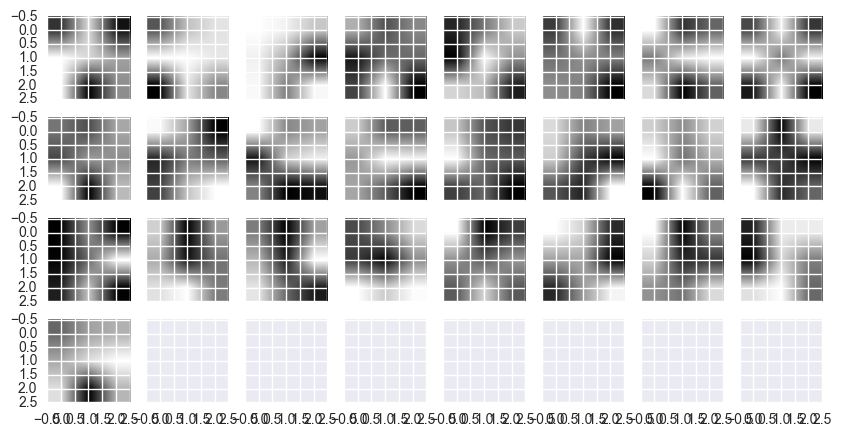

In [59]:
weights = model.layers[4].W.get_value(borrow=True).reshape(8, 25, 3, 3)[1]
print (weights.shape)
fig, axes = plt.subplots(4,8, sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = (10,5)
for i,w in enumerate(weights):
    axes[int(i/8)][int(i%8)].imshow(w)
    if(i == 31):
        break
plt.show()

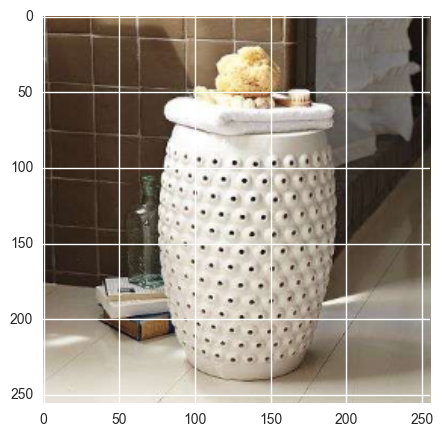

In [64]:
np.random.seed(4*4*4)
sample_image = X_test[np.random.randint(0, len(X_test))]
plt.imshow(sample_image.reshape(resolution_x, resolution_y, 3))
plt.show()

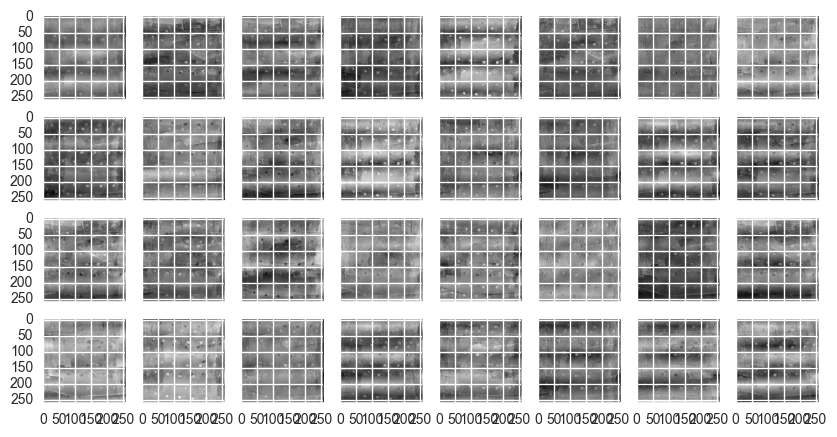

In [65]:
convout1_f = theano.function(model.inputs, [model.layers[0].output])
sample_outs = convout1_f([sample_image.astype(np.float32)])[0][0]

fig, axes = plt.subplots(4,8, sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = (10, 5)
for i,w in enumerate(sample_outs):
    axes[int(i/8)][int(i%8)].imshow(w, cmap="gray")
    #sns.heatmap(w)
    #plt.show()
plt.show()